In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 500

### Загрузим датасет с машинами. Цель - верно восстанавливать для каждой из них цену продажи!

In [22]:
data = pd.read_csv('autos.csv')

data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [23]:
### Колонка с тергетом - "selling price"

X = data.drop("selling_price", axis=1)
y = data["selling_price"]

### Будем замерять MSLE!
### Поэтому прологарифмируем таргет
### А после оптимизируем MSE

y = y.apply(np.log1p)

In [24]:
### Разделим выборку на трейн и тест!

from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

__Задание__ 

Реализуйте свой MeanTargetEncoder с добавленем некоторого шума!

Однажды в лекционном материале, обсуждая счетчики, мы говорили с вами о том, что из-за них модели могут переобучаться. Один из способов бороться с этим - валидировать расчеты среднего таргета (стратегия отложенной выборки / расчеты на кросс-валидации). Но есть еще проще!

Можно просто к значению счетчика добавить случайный шум (зашумить данные)!

Напомним, что рассчитываться новые признаки должны по такой формуле:

$$
g_j = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}{l} + C * \epsilon
$$


Пусть шум будет случайной величиной из нормального стандартного распределения, то есть $\epsilon \sim N(0, 1) $, а $ C = 0.006$.

Создавай свой класс-трансформер, наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`. Трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. 
Ваш трансформер должен принимать при инициализации список из категориальных признаков и список из числовых признаков. 

Если для какого-то признака в тестовой выборке отсутствует значение, трансформер должен поставить там 0.

На выходе должен получиться датасет того же размера с измененными категориальными признаками

In [25]:
object_cols = ['name', 'year', 'fuel', 'seller_type', 'transmission', 'owner']
num_cols = ['km_driven']

X.head()

,name,year,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,141000,Diesel,Individual,Manual,Second Owner


In [60]:
from sklearn.base import BaseEstimator, TransformerMixin

class MeanTargetEncoderNoise(BaseEstimator, TransformerMixin):
    
    def __init__(self, categorical, numeric):
        self.categorical = categorical
        self.numeric = numeric
        self.mean_target = {} # Словарь для хранения значений Mean Target для каждого категориального признака и каждого числового признака
        self.C = 0.006
    
    def fit(self, X, y):
        """
        Метод fit для расчета Mean Target для каждого категориального и числового признака.
        Расчет проводится только по обучающей выборке.
        :param X: pandas.DataFrame, обучающая выборка
        :param y: pandas.Series, значения целевой переменной для обучающей выборки
        :return: экземпляр класса MeanTargetEncoderNoise
        """
        for col in self.categorical:
            df = pd.DataFrame({'feature': X[col], 'target': y}) # Создаем DataFrame, чтобы сгруппировать значения по признаку
            mean_target = df.groupby(['feature'])['target'].mean() # Считаем среднее значение target для каждого значения признака
            self.mean_target[col] = mean_target  # Добавляем значения mean target в словарь
        
        for col in self.numeric:
            self.mean_target[col] = y.mean() # Для числовых признаков считаем среднее значение target по всей выборке
            
            return self
        
    def transform(self, X):
        """
        Метод transform для трансформации признаков с помощью Mean Target Encoding с добавлением шума.
        
        :param X: pandas.DataFrame, выборка для трансформации
        
        :return: pandas.DataFrame, трансформированная выборка
        """
        temp = X.copy()  # Создаем копию датасета, чтобы не изменять исходные данные
        
        for col in self.categorical:
            temp[col] = temp[col].map(self.mean_target[col]) # Заменяем значения категориального признака на значения mean target
            temp[col] = temp[col] + self.C * np.random.randn(len(X)) # Добавляем случайный шум
            temp[col] = temp[col].fillna(0) # Заполняем пропущенные значения 0
            
        for col in self.numeric:
            temp[col] = temp[col].fillna(self.mean_target[col]) # Заполняем пропущенные значения средним значением target по всей выборке
            
        return temp

In [61]:
### Проверка работы трансформера

np.random.seed(1)
transformer = MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)

transformer.fit(X_train, y_train)

train = transformer.transform(X_train)
test = transformer.transform(X_test)

train.head()

,name,year,km_driven,fuel,seller_type,transmission,owner
3294,13.478865,13.430921,50000,13.088541,12.609423,13.759065,12.964161
2290,12.111783,11.901925,70000,12.457036,12.620399,13.777324,12.962823
874,12.298593,13.336935,50000,12.455670,12.616451,12.645775,12.984195
1907,12.477658,13.055335,92198,12.463101,13.152012,12.637086,12.452642
3244,12.397144,12.857059,3240,12.454647,12.614863,12.627399,12.471970


Обучите несколько деревьев, перебирая максимальную глубину алгоритма из списка `max_depth_list`, а остальные параметры оставьте дефолтными. Выведите лучшее значение гиперпараметра. Постройте график зависимости MSLE на тестовой выборке от значения гиперпараметра. Воспользуйтесь `Pipeline` без `GridSearch`. Проделайте то же самое с `min_samples_split`, `min_impurity_decrease`, `max_leaf_nodes`. (по 2б на каждый параметр)

In [64]:
max_depth_list = [3, 5, 8, 12]
min_samples_split_list = [10, 50, 100, 500]
min_impurity_decrease_list = [0, 0.1, 0.15, 0.2]
max_leaf_nodes_list = [100, 200, 500]

In [ ]:
min

In [97]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

np.random.seed(1)
### Your code is here
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

max_depth_list = [1,2,3,4, 5, 8, 12]
result_test = {}
result_train = {}
for col in max_depth_list:
    pipe = Pipeline([("custom_transformer",
                   MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),
                  
                  
                 ("decision_tree", 
                  DecisionTreeRegressor(max_depth=col))])

    pipe.fit(X_train, y_train)

    mse_train =mse(y_train, pipe.predict(X_train))
    mse_test = mse(y_test, pipe.predict(X_test))
    max_depth = f'max_depth_{col}'
    result_test.update({max_depth:mse_test})
    result_train.update({max_depth:mse_train})

result_test


{'max_depth_1': 0.5212834985456157,
 'max_depth_2': 0.626720708557684,
 'max_depth_3': 0.7861836137784873,
 'max_depth_4': 0.9844293563424611,
 'max_depth_5': 1.4423379879439593,
 'max_depth_8': 1.45617182464722,
 'max_depth_12': 1.59276610655452}

In [96]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

np.random.seed(1)
### Your code is here
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

min_samples_split_list = [10, 50, 100, 500]
result_test2 = {}
result_train = {}
for col in min_samples_split_list:
    pipe = Pipeline([("custom_transformer",
                   MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),
                  
                  
                 ("decision_tree", 
                  DecisionTreeRegressor(min_samples_split=col))])

    pipe.fit(X_train, y_train)

    mse_train =mse(y_train, pipe.predict(X_train))
    mse_test = mse(y_test, pipe.predict(X_test))
    max_depth = f'max_depth_{col}'
    result_test2.update({max_depth:mse_test})
    result_train.update({max_depth:mse_train})

result_test2

{'max_depth_10': 2.009257501657573,
 'max_depth_50': 1.3874651673616962,
 'max_depth_100': 0.9918833021700725,
 'max_depth_500': 0.8142044447029735}

In [100]:
np.random.seed(1)
### Your code is here
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

min_impurity_decrease_list = [0, 0.1, 0.15, 0.2]
result_test3 = {}
result_train = {}
for col in min_impurity_decrease_list:
    pipe = Pipeline([("custom_transformer",
                   MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),
                  
                  
                 ("decision_tree", 
                  DecisionTreeRegressor(min_weight_fraction_leaf=col))])

    pipe.fit(X_train, y_train)

    mse_train =mse(y_train, pipe.predict(X_train))
    mse_test = mse(y_test, pipe.predict(X_test))
    max_depth = f'max_depth_{col}'
    result_test3.update({max_depth:mse_test})
    result_train.update({max_depth:mse_train})

result_test3

{'max_depth_0': 2.0190351811485354,
 'max_depth_0.1': 0.6053947170333622,
 'max_depth_0.15': 0.6016695842992648,
 'max_depth_0.2': 0.5954193031133456}

In [102]:
np.random.seed(1)
### Your code is here
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

max_leaf_nodes_list = [100, 200, 500]
result_test4 = {}
result_train = {}
for col in max_leaf_nodes_list:
    pipe = Pipeline([("custom_transformer",
                   MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),
                  
                  
                 ("decision_tree", 
                  DecisionTreeRegressor(max_features=col))])

    pipe.fit(X_train, y_train)

    mse_train =mse(y_train, pipe.predict(X_train))
    mse_test = mse(y_test, pipe.predict(X_test))
    max_depth = f'max_depth_{col}'
    result_test4.update({max_depth:mse_test})
    result_train.update({max_depth:mse_train})

result_test4

{'max_depth_100': 2.0190351811485354,
 'max_depth_200': 2.0044961826528565,
 'max_depth_500': 1.5994838523991932}

In [104]:
pipe = Pipeline([("custom_transformer",
                   MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),
                  
                  
                 ("decision_tree", 
                  DecisionTreeRegressor(max_depth=3, min_samples_split = 500, min_weight_fraction_leaf=0.2, max_features=500))])

pipe.fit(X_train, y_train)


print(mse(y_test, pipe.predict(X_test)))


0.5946883737080048


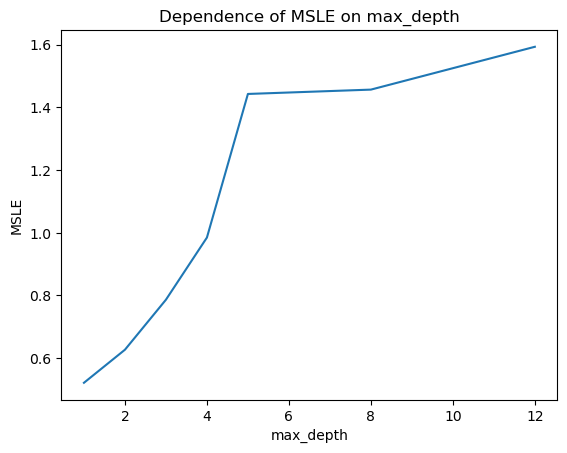

In [98]:
import matplotlib.pyplot as plt


depths = [int(key.split('_')[2]) for key in result_test.keys()]
scores = list(result_test.values())

plt.plot(depths, scores)
plt.xlabel('max_depth')
plt.ylabel('MSLE')
plt.title('Dependence of MSLE on max_depth')
plt.show()

Подберите лучшую комбинацию параметров, используя `GridSearchCV` и набор массивов значений параметров из предыдущего задания. Для лучшей комбинации посчитайте MSLE на тестовой выборке. Получились ли лучшие параметры такими же, как если бы вы подбирали их по-отдельности при остальных гиперпараметрах по умолчанию (предыдущее задание)? (2б)

In [107]:
from sklearn.model_selection import GridSearchCV

np.random.seed(1)

### Your code is here
from sklearn.model_selection import TimeSeriesSplit

splitter = TimeSeriesSplit(n_splits=3)

from sklearn.model_selection import GridSearchCV

param_grid = {
    "decision_tree__max_depth": [3, 5, 8, 12],
    "decision_tree__min_samples_split": [10, 50, 100, 500],
    "decision_tree__min_impurity_decrease": [0, 0.1, 0.15, 0.2],
    "decision_tree__max_leaf_nodes": [100, 200, 500]
}

### Передадим в GridSearchCV

search = GridSearchCV(pipe, 
                      param_grid, 
                      cv=splitter,
                      scoring='neg_mean_squared_error',
                      )

search.fit(X_train, y_train)

print(f"Best parameter (CV score={search.best_score_:.5f}):")
print(search.best_params_)

print(f"Качество лучшей модели на финальном тесте: {-search.score(X_test, y_test)}")




Best parameter (CV score=-0.66726):
{'decision_tree__max_depth': 8, 'decision_tree__max_leaf_nodes': 500, 'decision_tree__min_impurity_decrease': 0.2, 'decision_tree__min_samples_split': 500}
Качество лучшей модели на финальном тесте: 0.519436517120926
